In [49]:
import pandas as pd 
import numpy as np

import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

#firstly importing all packages needed

In [2]:
house = pd.read_csv('Data/kc_house_data.csv')

#importing the data set Kc House Data

In [3]:
#deciding which columns won't be useful and then dropping them

house.drop('id', axis=1, inplace=True)
house.drop('sqft_living15', axis=1, inplace=True)
house.drop('sqft_lot15', axis=1, inplace=True)
house.drop('lat', axis=1, inplace=True)
house.drop('long', axis=1, inplace=True)
house.drop('view', axis=1, inplace=True)

In [4]:
abs(house.corr()['price']).sort_values(ascending=False)

#looking the highest correlated variables to help decide which ones to deal with and use in the regression

price           1.000000
sqft_living     0.701917
grade           0.667951
sqft_above      0.605368
bathrooms       0.525906
bedrooms        0.308787
waterfront      0.276295
floors          0.256804
yr_renovated    0.129599
sqft_lot        0.089876
yr_built        0.053953
zipcode         0.053402
condition       0.036056
Name: price, dtype: float64

In [5]:
house.info()

#checking the data types of the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  zipcode        21597 non-null  int64  
dtypes: float64(5), int64(8), object(2)
memory usage: 2.5+ MB


In [6]:
house.select_dtypes(include=['object']).columns.tolist()

#seeing that some are objects, need to change these

['date', 'sqft_basement']

In [7]:
year = []
for date in house.date:
    year.append(int(date.split('/')[2]))
house['year'] = (year)

#dealing with the date column by splitting it into two seperate columns

In [8]:
house['year'] = house['year'].astype(float)

In [9]:
house.isnull().sum()

#checking whether there are any null values: waterfront, view and yr_renovated all have nulls

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
year                0
dtype: int64

In [10]:
house.fillna(value = 0, inplace=True)

#replacing the NaN's with 0

In [11]:
house.sqft_basement.value_counts()

#checking what the object type for sqft_basement entails, its apparent there are 454 "?"

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2360.0        1
1281.0        1
1880.0        1
283.0         1
768.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [12]:
house.sqft_basement.replace('?', '0.0', inplace=True)
house.sqft_basement.value_counts()

#converted the "?" to 0, assuming they are nothing

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
2360.0        1
1281.0        1
1880.0        1
283.0         1
768.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [13]:
house['sqft_basement'] = house['sqft_basement'].astype(float)

#now converting to a float works as we have changed the "?" to 0

In [14]:
house['price'].describe()

#checking the price min and max. the max is over 7 million and I am considering this to be not affordable for house
#buyers, planning to get rid of all prices over 1.5-2million.

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

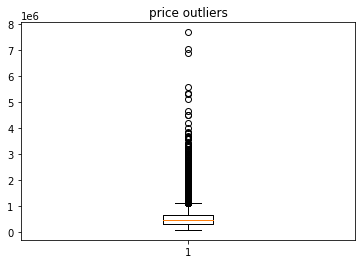

In [15]:
plt.boxplot(house['price'])
plt.title ("price outliers")
plt.show()

#looking at the outliers within price and where its concentrated

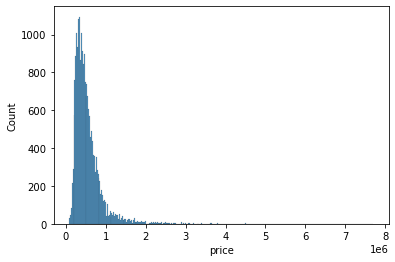

In [16]:
fig, ax = plt.subplots() 
sns.histplot(house['price']);

#histogram to see the price

In [17]:
quartiles = house['price'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
print(iqr)

#calculating the interquartile range to see where the majority of data lies

323000.0


In [18]:
house['price'].median()

#the median of price is $450000

450000.0

In [19]:
house['price'].mean()

#the mean house price is $540296.57

540296.5735055795

In [20]:
house_filt = house[(house['price'] < 1000000)].copy()
house_filt = house[(house['price'] > 100000)].copy()

#deciding to cut off the data at $1 million as the average and median are around half of 1 mil, also cutting off
#homes under $100,000

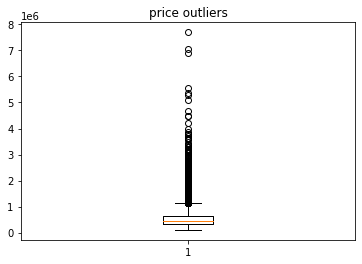

In [21]:
plt.boxplot(house_filt['price'])
plt.title("price outliers")
plt.show()

#checking the outliers after cutting off the house prices over 1 mil

In [22]:
house_filt = house_filt[(house_filt['bedrooms'] <= 2)].copy()

house_filt = house_filt[(house_filt['bathrooms'] <= 2)].copy()

#cutting off the bedrooms and bathrooms columns at 2 as this would be outside the target for the buyers

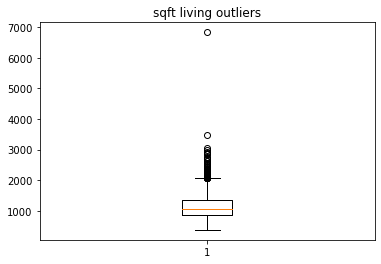

In [23]:
plt.boxplot(house_filt['sqft_living'])
plt.title ("sqft living outliers")
plt.show()

#looking at the outliers for sqft_living

In [24]:
house_filt['sqft_living'].median()

#the median is 4660sqft

1070.0

In [25]:
house_filt['sqft_living'].mean()

#the mean is 5007sqft

1149.5181004281822

In [26]:
house_filt = house_filt[(house_filt['sqft_living'] <= 2000)].copy()

#deciding to cut off sqft_living over 2000sqft to cut out the outliers

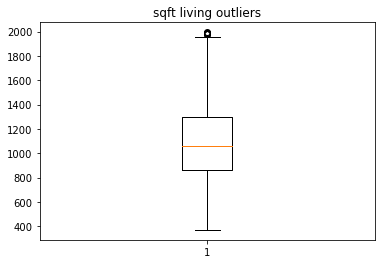

In [27]:
plt.boxplot(house_filt['sqft_living'])
plt.title ("sqft living outliers")
plt.show()

#checking the outliers now

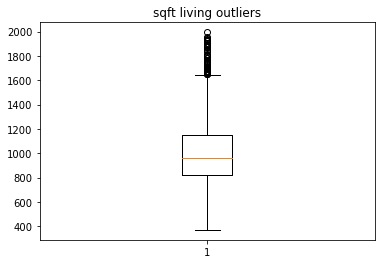

In [28]:
plt.boxplot(house_filt['sqft_above'])
plt.title ("sqft living outliers")
plt.show()

#looking at the outliers for sqft_above

In [29]:
house_filt['sqft_above'].mean()

1006.1933010492332

In [30]:
house_filt['sqft_above'].median()

#the median for sqft_above is 3805.0

960.0

In [31]:
house_filt = house_filt[(house_filt['sqft_above'] <= 1700)].copy()

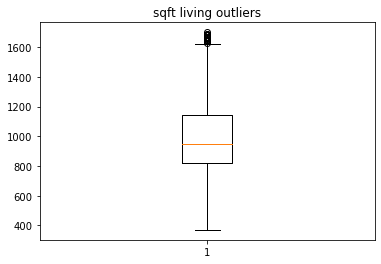

In [32]:
plt.boxplot(house_filt['sqft_above'])
plt.title ("sqft living outliers")
plt.show()

<AxesSubplot:>

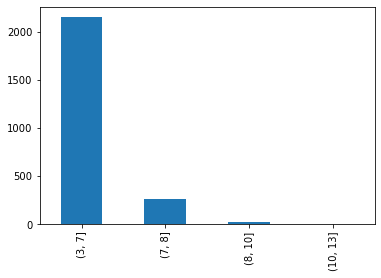

In [33]:
#dealing with categorical variables by creating dummy variables

bins = [3,7,8,10,13]
bins_grade = pd.cut(house_filt['grade'],bins)
bins_grade.value_counts().plot(kind='bar')

In [34]:
bins_grade = bins_grade.cat.as_unordered()
grade_dummy = pd.get_dummies(bins_grade, prefix='grade')

#created the dummy variabels for grade because grade is in categories

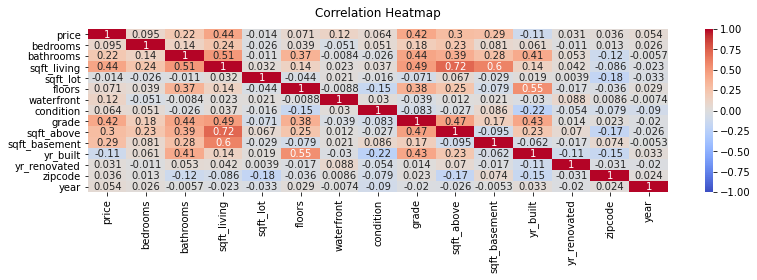

In [35]:
#looking at a correlation heatmap to see which variables are closely related
#sqft_living and sqft_above have a higher correlation

plt.figure(figsize=(13, 3))
heatmap = sns.heatmap(house_filt.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [36]:
#decided to drop sqft_above due to high multicollinearity

house_filt.drop('sqft_above', axis=1, inplace=True)

Model Creating

First model: baseline model

The first model made was a baseline model that incldued the dependent variable which was price and the top correlated independent variable which was sqft_living. A train test split was performed to a 30% test and 70% train structure. 

In [37]:
#creating the test and train model

X = house_filt[['sqft_living']]
Y = house_filt['price']

X_train, X_test,Y_train,Y_test = train_test_split(X, Y,test_size =0.3)
X_test

,sqft_living
16325,830
6448,1840
10385,1600
6387,1980
8174,1270
...,...
14921,1320
2163,1088
16523,1240
12153,1630


In [38]:
#created the base model

predictors = X_test
predictors_int = sm.add_constant(predictors)
base_model = sm.OLS(Y_test,predictors_int).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     175.1
Date:                Sun, 24 Sep 2023   Prob (F-statistic):           5.65e-36
Time:                        20:26:30   Log-Likelihood:                -9676.7
No. Observations:                 731   AIC:                         1.936e+04
Df Residuals:                     729   BIC:                         1.937e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.255e+05   1.86e+04      6.763      0.000     8.9e+04    1.62e+05
sqft_living   216.3117     16.348     13.232      0.000     184.217     248.407
==============================================================================
Omnibus:                       82.728   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.488
Skew:                           0.748   Prob(JB):                     2.30e-30
Kurtosis:                       4.499   Cond. No.                     4.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

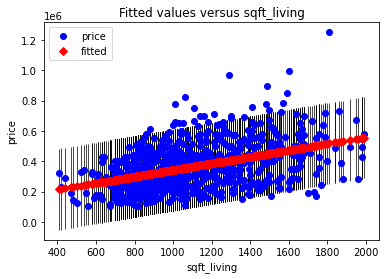

In [39]:
sm.graphics.plot_fit(base_model, 'sqft_living')
plt.show()

#showing the price and the fitted values vs sqft living

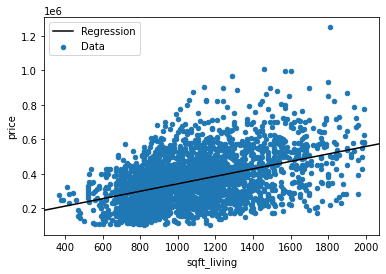

In [40]:
fig, ax = plt.subplots()
house_filt.plot.scatter(x='sqft_living', y='price', label ='Data', ax=ax)
sm.graphics.abline_plot(model_results=base_model, label= 'Regression', ax=ax, color='black')
ax.legend();

In [41]:
abs(house_filt.corr()['price']).sort_values(ascending=False)

price            1.000000
sqft_living      0.441421
grade            0.423625
sqft_basement    0.288443
bathrooms        0.222240
waterfront       0.117506
yr_built         0.109805
bedrooms         0.095443
floors           0.070696
condition        0.064485
year             0.053824
zipcode          0.036201
yr_renovated     0.031049
sqft_lot         0.013904
Name: price, dtype: float64

# Model Two

For model two, I brought in the top correlated variables for the regression. This included sqft_living, grade, sqft_basement, bathrooms, bedrooms, waterfront and yr_built. 

In [42]:
X_2 = house_filt[['sqft_living', 'grade', 'sqft_basement', 'bathrooms', 'waterfront', 'yr_built', 'bedrooms']]

model_2 = sm.OLS(Y,sm.add_constant(X_2))
model_2_results = model_2.fit()
model_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     195.4
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          3.22e-230
Time:                        20:26:30   Log-Likelihood:                -31894.
No. Observations:                2434   AIC:                         6.380e+04
Df Residuals:                    2426   BIC:                         6.385e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.159e+06   1.84e+05     17.127      0.000     2.8e+06    3.52e+06
sqft_living     110.2521     12.210      9.029      0.000      86.308     134.196
grade              8e+04   3751.286     21.327      0.000    7.26e+04    8.74e+04
sqft_basement    30.3883     14.897      2.040      0.041       1.175      59.601
bathrooms      1.919e+04   8712.856      2.202      0.028    2102.610    3.63e+04
waterfront       2.1e+05    2.9e+04      7.228      0.000    1.53e+05    2.67e+05
yr_built      -1767.9747     99.040    -17.851      0.000   -1962.187   -1573.763
bedrooms      -1.353e+04   9542.929     -1.418      0.156   -3.22e+04    5178.406
==============================================================================
Omnibus:                      258.390   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              496.694
Skew:                           0.689   Prob(JB):                    1.39e-108
Kurtosis:                       4.732   Cond. No.                     1.72e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

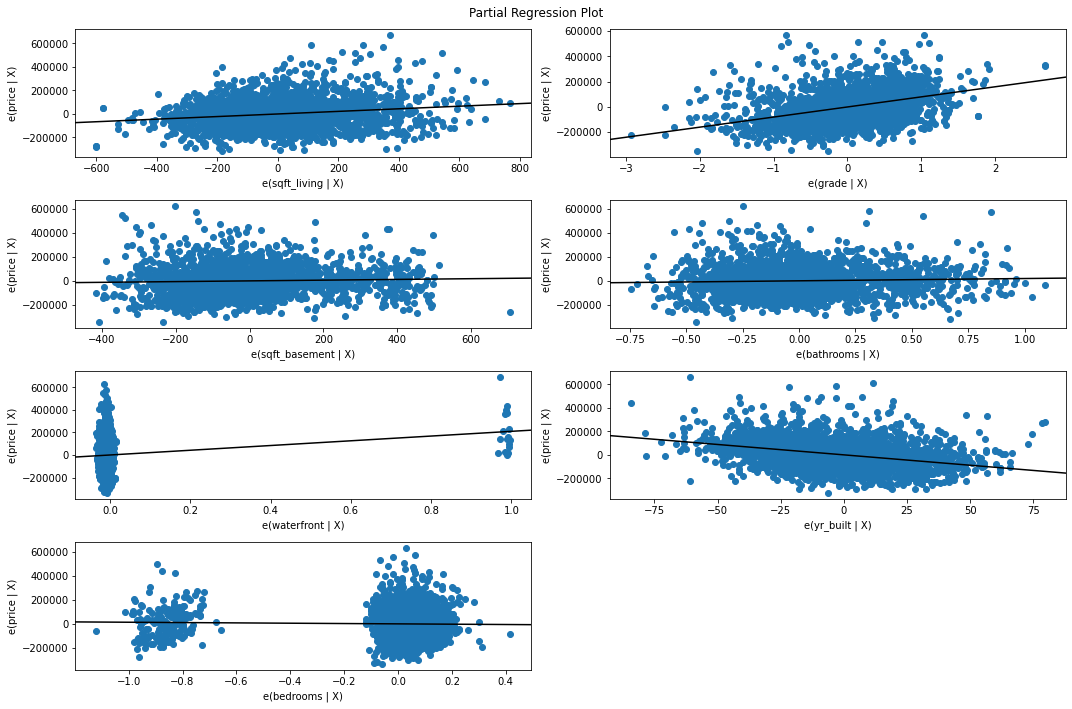

In [43]:
fig = plt.figure(figsize=(15,10))
sm.graphics.plot_partregress_grid(model_2_results, exog_idx=['sqft_living', 'grade', 'sqft_basement', 'bathrooms', 'waterfront', 'yr_built', 'bedrooms'], fig=fig)
plt.tight_layout()
plt.show()

# Model 3

In [44]:
X_3 = house_filt[['sqft_living', 'grade', 'sqft_basement', 'bathrooms', 'yr_built']]

model_3 = sm.OLS(Y,sm.add_constant(X_3))
model_3_results = model_3.fit()
model_3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     256.8
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          9.55e-221
Time:                        20:26:31   Log-Likelihood:                -31922.
No. Observations:                2434   AIC:                         6.386e+04
Df Residuals:                    2428   BIC:                         6.389e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.152e+06   1.86e+05     16.979      0.000    2.79e+06    3.52e+06
sqft_living     110.6077     12.136      9.114      0.000      86.809     134.406
grade           7.84e+04   3781.920     20.731      0.000     7.1e+04    8.58e+04
sqft_basement    31.6411     15.019      2.107      0.035       2.190      61.092
bathrooms      1.878e+04   8808.185      2.132      0.033    1508.717    3.61e+04
yr_built      -1771.3892    100.114    -17.694      0.000   -1967.706   -1575.072
==============================================================================
Omnibus:                      308.070   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              664.527
Skew:                           0.759   Prob(JB):                    5.01e-145
Kurtosis:                       5.061   Cond. No.                     1.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As for model three, not much has changed by removing the variables waterfront and bedrooms. The variable coefficients have mainly stayed the same and the p values are all still statistically significant as expected from the last mode. the overall model is also still statistically significant. For model 4 a log transformation will be performed.  

In [45]:
#log transformation

x_log = np.log(X_3)
x_log

<ipython-input-45-2dc01d8e1163>:3: RuntimeWarning: divide by zero encountered in log
  x_log = np.log(X_3)


,sqft_living,grade,sqft_basement,bathrooms,yr_built
2,6.646391,1.791759,-inf,0.000000,7.566828
11,7.056175,1.945910,5.703782,0.000000,7.571474
18,7.090077,1.945910,-inf,0.000000,7.560601
23,6.975414,1.945910,-inf,0.405465,7.593374
31,7.081709,1.945910,-inf,0.405465,7.603399
...,...,...,...,...,...
21562,6.845880,1.945910,-inf,0.405465,7.605392
21567,6.565265,1.945910,-inf,0.000000,7.571988
21572,7.098376,2.079442,5.247024,0.405465,7.604396
21594,6.927558,1.945910,-inf,-0.287682,7.605392


# Model 4

In [46]:
X_4 = X_3
X_4 = house_filt[['sqft_living', 'grade', 'sqft_basement', 'bathrooms', 'yr_built']]

model_4 = sm.OLS(Y,sm.add_constant(X_4))
model_4_results = model_4.fit()
model_4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     256.8
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          9.55e-221
Time:                        20:26:32   Log-Likelihood:                -31922.
No. Observations:                2434   AIC:                         6.386e+04
Df Residuals:                    2428   BIC:                         6.389e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.152e+06   1.86e+05     16.979      0.000    2.79e+06    3.52e+06
sqft_living     110.6077     12.136      9.114      0.000      86.809     134.406
grade           7.84e+04   3781.920     20.731      0.000     7.1e+04    8.58e+04
sqft_basement    31.6411     15.019      2.107      0.035       2.190      61.092
bathrooms      1.878e+04   8808.185      2.132      0.033    1508.717    3.61e+04
yr_built      -1771.3892    100.114    -17.694      0.000   -1967.706   -1575.072
==============================================================================
Omnibus:                      308.070   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              664.527
Skew:                           0.759   Prob(JB):                    5.01e-145
Kurtosis:                       5.061   Cond. No.                     1.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
train_residuals = y_hat_train - Y_train
test_residuals = y_hat_test - Y_test
train_mse = mean_squared_error(Y_train, y_hat_train)
test_mse = mean_squared_error(Y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 17446725401.30577
Test Mean Squared Error: 18478287278.58622


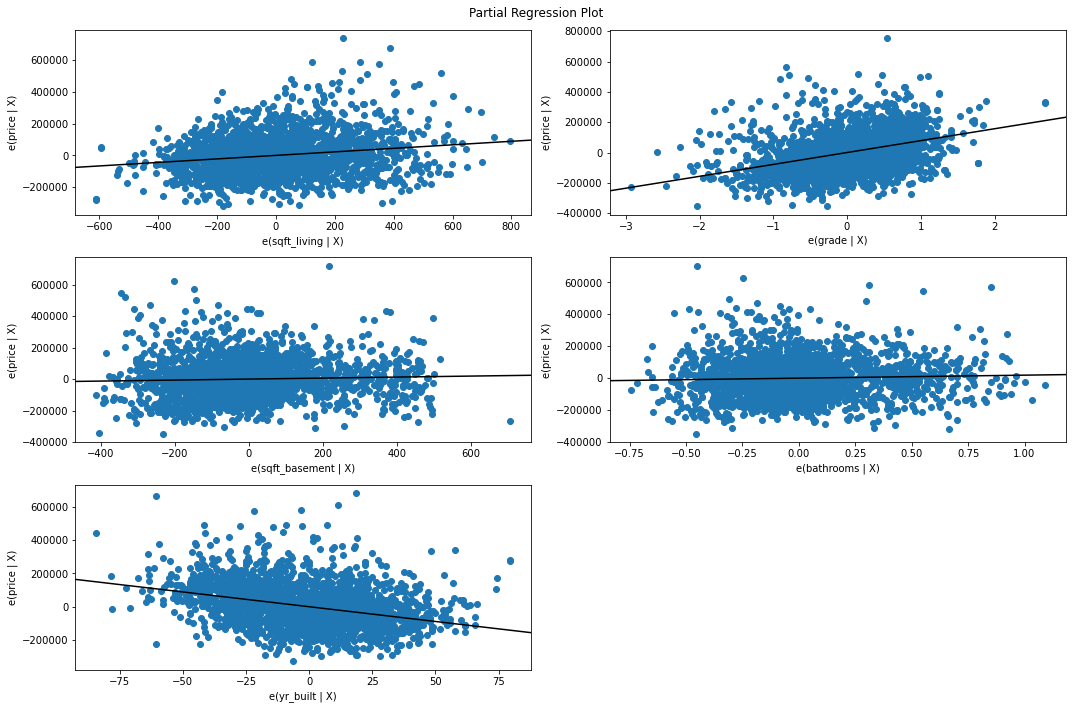

In [51]:
fig = plt.figure(figsize=(15,10))
sm.graphics.plot_partregress_grid(model_4_results, exog_idx=['sqft_living', 'grade', 'sqft_basement', 'bathrooms', 'yr_built'], fig=fig)
plt.tight_layout()
plt.show()

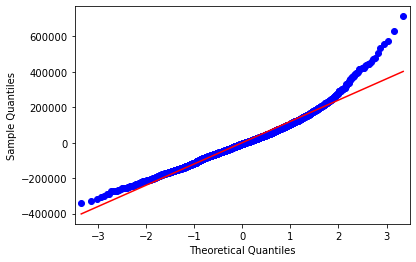

In [52]:
sm.qqplot(model_4_results.resid, line='s');

#QQ plot

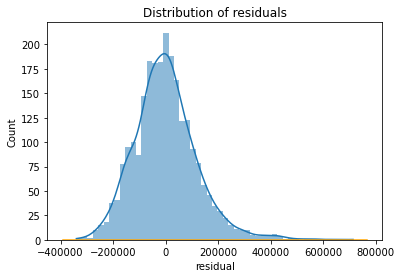

In [55]:
mu, std = stats.norm.fit(model_4_results.resid)
mu, std

fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=model_4_results.resid, ax=ax, stat="count", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

#showing the residuals